### Project description

The project is about predicting the number of recommendations of a comment performed on New York Times Comments
dataset that can be found under the link https://www.kaggle.com/datasets/aashita/nyt-comments.
Main challanges of this project are:
* handling large data volume
* feature engineering
* etc..
To 

### Imports

In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DateType
import pandas as pd

In [2]:
from pyspark import SparkContext, SparkConf
conf = SparkConf().setMaster("local[8]").setAppName("big_data")
sc = SparkContext.getOrCreate(conf=conf)

22/06/25 17:49:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [3]:
spark = SparkSession.builder.getOrCreate()

### Reading data

In [4]:
def read_spark_df(path):
    return spark.read.option("multiline",True).option('lineSep','\n').option("header", True).option("delimiter", ",").option("inferSchema",True).option("escapeQuotes", True).option("quote", "\"").option("escape", "\"").csv(path)

In [39]:
articles_df = read_spark_df('data/nyt-articles-2020.csv')


comments_df = read_spark_df('data/nyt-comments-2020.csv')

In [40]:
articles_df.printSchema()

root
 |-- newsdesk: string (nullable = true)
 |-- section: string (nullable = true)
 |-- subsection: string (nullable = true)
 |-- material: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- pub_date: string (nullable = true)
 |-- n_comments: integer (nullable = true)
: string (nullable = true)



In [41]:
comments_df = comments_df.limit(1000)

In [42]:
df = comments_df.withColumn("updateDate", comments_df['updateDate'].cast(DateType()))

In [43]:
comments_df.printSchema()

root
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: string (nullable = true)
 |-- updateDate: string (nullable = true)
 |-- approveDate: string (nullable = true)
 |-- recommendations: integer (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: boolean (nullable = true)
 |-- parentID: double (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: integer (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: integer (nullable = true)
 |-- isAnonymous: boolean (nullable = true)
 |-- articleID: string (nullable = true)


We can observe that although we used inferSchema some of the columns should be stored as a different data type. Let's fix it.

In [44]:
comments_df=comments_df.withColumn('recommendations',comments_df['recommendations'].cast("float"))\
                        .withColumn("createDate", comments_df['createDate'].cast(DateType()))\
                        .withColumn("updateDate", comments_df['updateDate'].cast(DateType()))\
                        .withColumn("approveDate", comments_df['approveDate'].cast(DateType()))\
                        .withColumn('replyCount',comments_df['replyCount'].cast("int"))\
                        .withColumn('depth',comments_df['depth'].cast("int"))\
                        .withColumn('isAnonymous',comments_df['isAnonymous'].cast("int"))\
                        .withColumn('editorsSelection',comments_df['editorsSelection'].cast("int"))
#actually some of the above columns are boolean but pyspark does not provide such datatype so we cast them to int

In [45]:
articles_df = articles_df.withColumn('word_count',articles_df['word_count'].cast("int"))\
                         .withColumn("pub_date", articles_df['pub_date'].cast(DateType()))\
                         .withColumn('n_comments',articles_df['n_comments'].cast("int"))

In [46]:
comments_df.printSchema()

root
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: date (nullable = true)
 |-- updateDate: date (nullable = true)
 |-- approveDate: date (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: integer (nullable = true)
 |-- parentID: double (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: integer (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: integer (nullable = true)
 |-- isAnonymous: integer (nullable = true)
 |-- articleID: string (nullable = true)



In [47]:
articles_df.printSchema()

root
 |-- newsdesk: string (nullable = true)
 |-- section: string (nullable = true)
 |-- subsection: string (nullable = true)
 |-- material: string (nullable = true)
 |-- headline: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- keywords: string (nullable = true)
 |-- word_count: integer (nullable = true)
 |-- pub_date: date (nullable = true)
 |-- n_comments: integer (nullable = true)
: string (nullable = true)



Let's take a look at our target variable

In [48]:
comments_df.describe(['recommendations']).show()

+-------+-----------------+
|summary|  recommendations|
+-------+-----------------+
|  count|             1000|
|   mean|           11.986|
| stddev|27.61623545055446|
|    min|              0.0|
|    max|            402.0|
+-------+-----------------+



We can observe that data is contains outliers. We will get rid of them using quantiles.

In [49]:
upper_limit = comments_df.approxQuantile('recommendations', [ 0.9], 0.05)[0]

In [50]:
comments_df = comments_df.filter((col('recommendations')<upper_limit))

In [51]:
comments_df.describe(['recommendations']).show()

+-------+-----------------+
|summary|  recommendations|
+-------+-----------------+
|  count|              852|
|   mean|4.772300469483568|
| stddev|5.022607677901019|
|    min|              0.0|
|    max|             20.0|
+-------+-----------------+



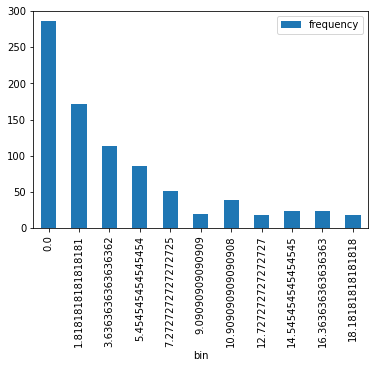

In [52]:
gre_histogram = comments_df.select('recommendations').rdd.flatMap(lambda x: x).histogram(11)

# Loading the Computed Histogram into a Pandas Dataframe for plotting
pd.DataFrame(
    list(zip(*gre_histogram)), 
    columns=['bin', 'frequency']
).set_index(
    'bin'
).plot(kind='bar');

Transformr text to vectors

In [53]:
from pyspark.ml.feature import StopWordsRemover,Word2Vec
from pyspark.sql.functions import monotonically_increasing_id, row_number
from pyspark.sql.window import Window
import pyspark.sql.functions as F

In [54]:
comments_df=comments_df.withColumn("createDateInt", F.unix_timestamp(comments_df['createDate']))

aritcles_data = articles_df.select(col("abstract"),col("pub_date"),
                          col("keywords"),
                          col("uniqueID\r").alias('articleID'))
aritcles_data = aritcles_data.withColumn("pubDateInt", F.unix_timestamp(col('pub_date')))
# aritcles_data = aritcles_data.filter(~ col('abstract').isNull()) # TODO: nie wywalać tylko uzpełniać średnią wartośćią z wek

In [55]:
articles_df.show()

+--------------+------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+----------+----------+--------------------+
|
+--------------+------------------+-----------+-------------------+--------------------+--------------------+--------------------+----------+----------+----------+--------------------+
|     Editorial|           Opinion|       null|          Editorial|Protect Veterans ...|Congress could do...|['Veterans', 'For...|       680|2020-01-01|       186|nyt://article/69a...|
|         Games|Crosswords & Games|       null|               News|‘It’s Green and S...|Christina Iverson...|['Crossword Puzzl...|       931|2020-01-01|       257|nyt://article/9ed...|
|       Science|           Science|       null|               News|Meteor Showers in...|All year long, Ea...|['Meteors and Met...|      1057|2020-01-01|         6|nyt://article/04b...|
|       Science|           Science|       null|Interactive Feature|Sync y

In [56]:
aritcles_data.show()

+--------------------+----------+--------------------+--------------------+----------+
|            abstract|  pub_date|            keywords|           articleID|pubDateInt|
+--------------------+----------+--------------------+--------------------+----------+
|Congress could do...|2020-01-01|['Veterans', 'For...|nyt://article/69a...|1577833200|
|Christina Iverson...|2020-01-01|['Crossword Puzzl...|nyt://article/9ed...|1577833200|
|All year long, Ea...|2020-01-01|['Meteors and Met...|nyt://article/04b...|1577833200|
|Never miss an ecl...|2020-01-01|['Space and Astro...|nyt://interactive...|1577833200|
|A year full of hi...|2020-01-01|['Space and Astro...|nyt://article/bd8...|1577833200|
|Iran’s ability to...|2020-01-01|['Iraq', 'Iran', ...|nyt://article/ac7...|1577833200|
|If you brother-in...|2020-01-01|['Comedy and Humor']|nyt://article/dea...|1577833200|
|After the 67-year...|2020-01-01|['Stroke', 'Brain...|nyt://article/dfd...|1577833200|
|Tangy and juicy, ...|2020-01-01|['Cooking 

In [271]:
def get_vector(df,column='commentBody',leave_columns =["commentID"]):
    df_without_nulls = df.filter(~ col(column).isNull())
    df_with_nulls = df.filter(col(column).isNull()).drop(column)
    df_without_nulls = df_without_nulls.withColumn(column, trim(regexp_replace(column,'(@\w+)|[^a-zA-Z\s]', '')))
    df_without_nulls = df_without_nulls.select(*leave_columns,split(col(column)," ").alias(column))
    remover = StopWordsRemover(inputCol=column, outputCol="filtered")
    filtered = remover.transform(df_without_nulls)
    word2vec = Word2Vec(inputCol="filtered", outputCol=f"feature_{column}")
    model = word2vec.fit(filtered)
    vectorized = model.transform(filtered)
    vectorized = vectorized.drop("filtered",column)
    df_with_nulls = df_with_nulls.withColumn(f"feature_{column}",lit(None))
    mean_vector = vectorized.agg(Summarizer.mean(vectorized[f"feature_{column}"])).collect()[0][f'mean(feature_{column})']
    print(mean_vector,type(mean_vector))
    df = df_with_nulls.unionByName(vectorized)
    df = df.fillna(value=mean_vector,subset=[f"feature_{column}"]).show()
#     df = df.withColumn(f"feature_{column}",when(col(f"feature_{column}").isNull(),mean_vector.toArray())
#     .otherwise(f"feature_{column}"))
#     if df_without_nulls.count() > 0 :
#         
#         df_without_nulls = df_without_nulls.withColumn(f"feature_{column}",mean_vector)
    return vectorized

In [272]:
aritcles_data.filter(col('abstract').isNull()).show()

+--------+----------+--------------------+--------------------+----------+
|abstract|  pub_date|            keywords|           articleID|pubDateInt|
+--------+----------+--------------------+--------------------+----------+
|    null|2020-02-10|['Magazines', 'Wo...|nyt://interactive...|1581289200|
|    null|2020-04-08|['United States E...|nyt://interactive...|1586296800|
|    null|2020-04-10|['Coronavirus (20...|nyt://article/8db...|1586469600|
+--------+----------+--------------------+--------------------+----------+



In [273]:
comments_df_leave_columns = ['commentID','createDateInt','approveDate','recommendations','articleID','replyCount']

In [274]:
comments_df.printSchema()

root
 |-- commentID: integer (nullable = true)
 |-- status: string (nullable = true)
 |-- commentSequence: integer (nullable = true)
 |-- userID: integer (nullable = true)
 |-- userDisplayName: string (nullable = true)
 |-- userLocation: string (nullable = true)
 |-- userTitle: string (nullable = true)
 |-- commentBody: string (nullable = true)
 |-- createDate: date (nullable = true)
 |-- updateDate: date (nullable = true)
 |-- approveDate: date (nullable = true)
 |-- recommendations: float (nullable = true)
 |-- replyCount: integer (nullable = true)
 |-- editorsSelection: integer (nullable = true)
 |-- parentID: double (nullable = true)
 |-- parentUserDisplayName: string (nullable = true)
 |-- depth: integer (nullable = true)
 |-- commentType: string (nullable = true)
 |-- trusted: integer (nullable = true)
 |-- recommendedFlag: integer (nullable = true)
 |-- permID: integer (nullable = true)
 |-- isAnonymous: integer (nullable = true)
 |-- articleID: string (nullable = true)
 |-- cre

In [275]:
from pyspark.sql.functions import lit


In [276]:
articles_columns = aritcles_data.columns
articles_columns.pop(articles_columns.index('abstract'))
articles_df_leave_columns = articles_columns
# df = get_vector(comments_df,leave_columns=comments_df_leave_columns)
df2 = get_vector(aritcles_data, column='abstract',leave_columns = articles_df_leave_columns)
# articles_columns = df2.columns
# articles_columns.pop(articles_columns.index('keywords'))
# articles_df_leave_columns = articles_columns
# df2 = get_vector(df2, column='keywords',leave_columns = articles_df_leave_columns)

22/06/25 18:26:47 WARN StopWordsRemover: Default locale set was [en_PL]; however, it was not found in available locales in JVM, falling back to en_US locale. Set param `locale` in order to respect another locale.


[-0.0012441148660482198,-0.010444739975608665,0.0009012345517454203,-0.031392856958430096,0.010793640420163304,0.004788966611589248,-0.0012296892581977283,-0.0025237151558445098,0.0018830831073420329,-0.014219584344508533,-0.0013861245997048735,0.009845024454104897,0.005221266376093911,-0.00815617100233778,0.015061516951221468,-0.0040428446732921515,-0.009530282837351252,0.005678722896605618,-0.02453681289036581,-0.013541116265029993,-0.005891485428059491,0.021212994753872963,-0.00890485192744306,-0.011564499974102534,0.0031095371262640364,-0.01994149017878402,0.008532907608074465,0.0026640219517717737,-0.010156986584591443,0.009051973489279783,0.010573908541227113,-0.03354995560083085,0.009727089403236095,-0.014882090031981494,-0.005810592986545153,-0.006152665714236879,-0.004950966921680708,0.0050323325193487615,-0.01887474955708407,0.01713316526806824,0.008636498074683623,0.012209067322886104,-0.021530365671933796,-0.01213663211657956,0.014986533819392469,-0.0031585971843231695,-0.0

ValueError: value should be a float, int, string, bool or dict

In [ ]:
df2

In [28]:
from pyspark.ml.stat import Summarizer
# df.agg(Summarizer.mean(sdf.Vec)).show()

NameError: name 'sdf' is not defined

In [37]:
df2.agg(Summarizer.mean(df2.feature_abstract)).toPandas()['mean(feature_abstract)']

0    [-0.0012441148660482198, -0.010444739975608665...
Name: mean(feature_abstract), dtype: object

In [ ]:
df.show()
df2.show()

In [ ]:
df = df.withColumn("articleID", regexp_replace('articleID', '\r', ''))
df2 = df2.withColumn("articleID", regexp_replace('articleID', '\r', ''))

In [ ]:
full_df = df.join(df2,on='articleID',how='inner')

In [ ]:
from pyspark.sql.types import DoubleType

In [ ]:
full_df = full_df.withColumn('time_passed', abs(full_df['pubDateInt'] - full_df['createDateInt']).cast(DoubleType()))
full_df = full_df.drop('pubDateInt','createDateInt')

In [ ]:
from pyspark.ml.feature import StandardScaler
from pyspark.ml.feature import VectorAssembler

In [ ]:
def standarize_num_column(df,columns=['time_passed']):
    for column in columns:
        df = VectorAssembler(
          inputCols=[column], outputCol=f"{column}_vector"
        ).transform(df)

        df = StandardScaler(
              inputCol=f"{column}_vector", outputCol=f"scaled_{column}",
              withStd=True, withMean=False
            ).fit(df).transform(df)
        df = df.drop(f"{column}_vector",column)
    return df

In [ ]:
full_df = standarize_num_column(full_df,['time_passed','replyCount'])

In [ ]:
full_df.select('scaled_time_passed').distinct().show()

In [ ]:
from pyspark.ml.feature import VectorAssembler

numericCols = ['feature_abstract', 'feature_commentBody', 'scaled_time_passed','scaled_replyCount']
assembler = VectorAssembler(inputCols=numericCols, outputCol="features")
full_df = assembler.transform(full_df).drop(*numericCols)

In [ ]:
full_df = full_df

In [ ]:
from pyspark.ml.feature import Bucketizer
bucketizer = Bucketizer(splits=[ 0, 6, 12, 18, float('Inf') ],inputCol="recommendations", outputCol="buckets")
full_df = bucketizer.setHandleInvalid("keep").transform(full_df)

In [ ]:
full_df.printSchema()

In [ ]:
#### TODO ####

# from pyspark.mllib.linalg.distributed import RowMatrix
# from pyspark.mllib.linalg import Vectors, VectorUDT
# from pyspark.sql.functions import udf, array

# mat = RowMatrix(full_df.select('features'))
# pc = mat.computePrincipalComponents(10)
# projected = mat.multiply(pc)

In [ ]:
from pyspark.ml.feature import PCA

pca = PCA(k=30, inputCol="features")
pca.setOutputCol("pca_features")
df = pca.fit(full_df).transform(full_df)
df = df.drop('features').withColumn('features',col('pca_features'))
df.printSchema()

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Load and parse the data file, converting it to a DataFrame.
data = df

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="buckets", outputCol="indexedLabel").fit(data)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorIndexer(inputCol="features", outputCol="indexedFeatures").fit(data)

# Split the data into training and test sets (30% held out for testing)
(trainingData, testData) = data.randomSplit([0.7, 0.3])

# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="buckets", featuresCol="indexedFeatures")

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)

# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])

# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)

# Make predictions.
predictions = model.transform(testData)

# Select example rows to display.
predictions.select("predictedLabel", "buckets", "features").show(15)

# Select (prediction, true label) and compute test error
evaluator = MulticlassClassificationEvaluator(
    labelCol="buckets", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Error = %g" % (1.0 - accuracy))

rfModel = model.stages[2]
print(rfModel)  # summary only